## Diabetes Prediction model

### Problem Statement

Diagnostically predict whether or not a patient has diabetes, based on 
certain diagnostic measurements included in the dataset such as 
Pregnancies, Insulin, Glucose, Age etc..

### Python Implementation

In [5]:
#Let's start with importing necessary libraries

import pandas as pd 
import numpy as np 
from sklearn.preprocessing import StandardScaler 
from sklearn.linear_model  import Ridge,Lasso,RidgeCV, LassoCV, ElasticNet, ElasticNetCV, LogisticRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
#import scikitplot as skl
sns.set()

import warnings 
from warnings import filterwarnings
filterwarnings("ignore")

In [6]:
data = pd.read_csv("diabetes.csv") # Reading the Data
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [7]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

It seems that there are no missing values in our data. Great, let's see the distribution of data:

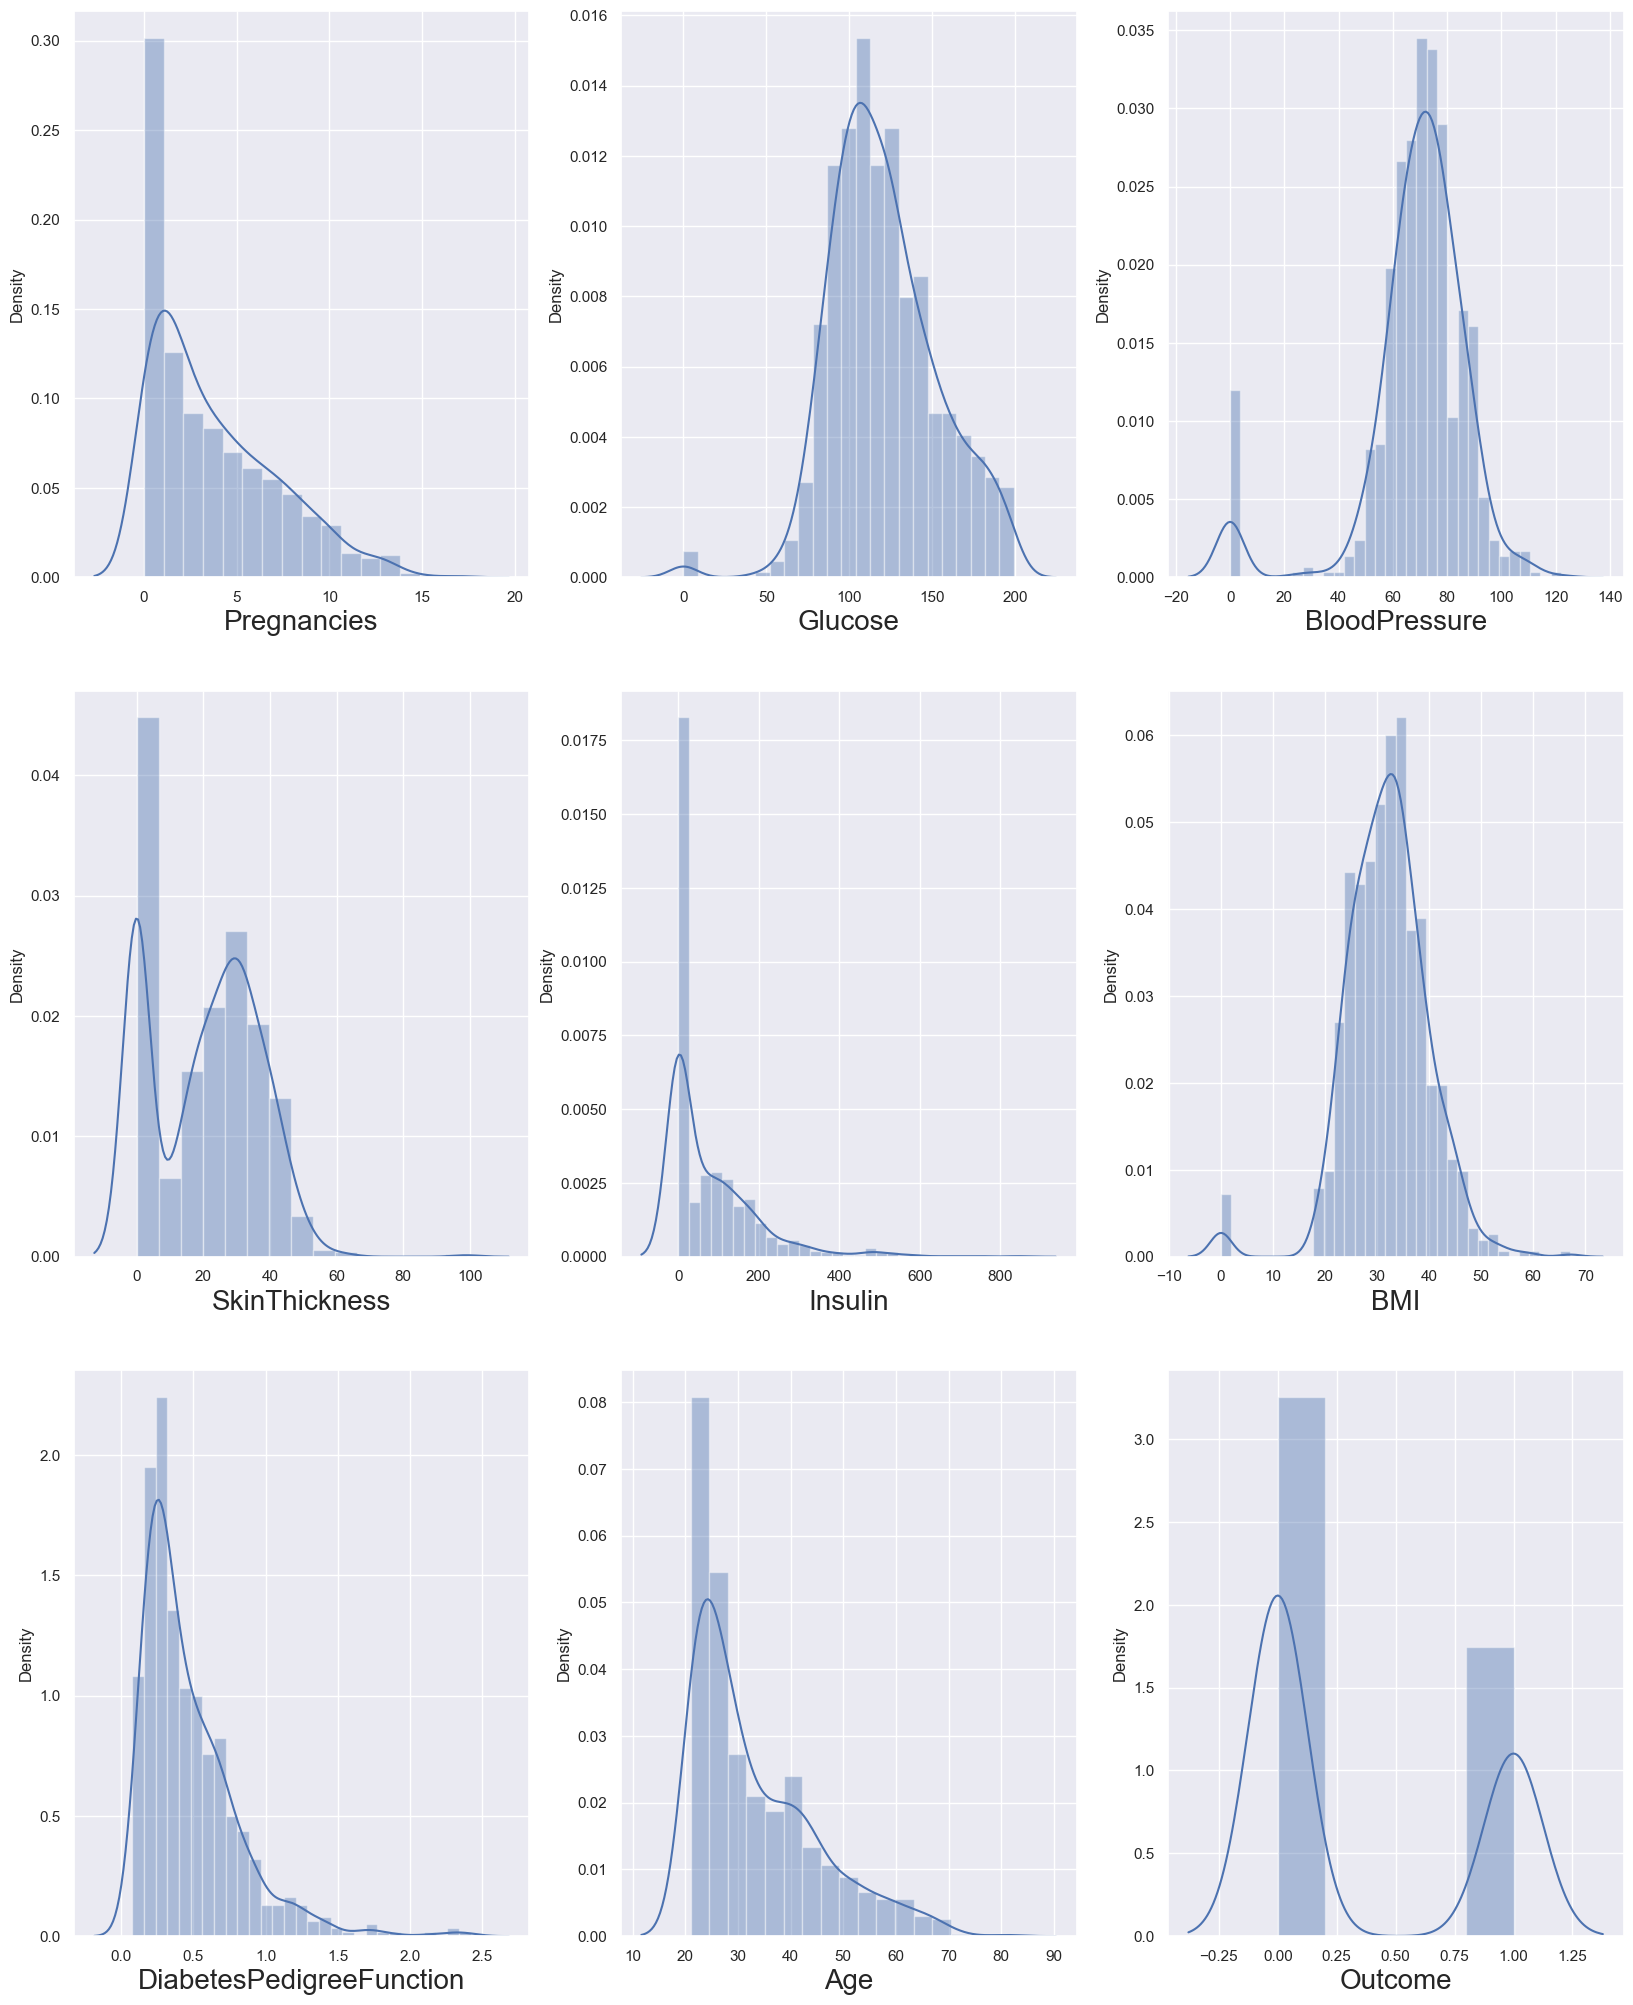

In [10]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data:
    if plotnumber<=9 :     # as there are 9 columns in the data
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.show()

We can see there is some skewness in the data, let's deal with data.

Also, we can see there few data for columns Glucose, Insulin, skin thickness, BMI and Blood Pressure which have value as 0. That's not possible. You can do a quick search to see that one cannot have 0 values for these. Let's deal with that. we can either remove such data or simply replace it with their respective mean values. Let's do the latter.

In [11]:
# replacing zero values with the mean of the column
data['BMI'] = data['BMI'].replace(0,data['BMI'].mean())
data['BloodPressure'] = data['BloodPressure'].replace(0,data['BloodPressure'].mean())
data['Glucose'] = data['Glucose'].replace(0,data['Glucose'].mean())
data['Insulin'] = data['Insulin'].replace(0,data['Insulin'].mean())
data['SkinThickness'] = data['SkinThickness'].replace(0,data['SkinThickness'].mean())

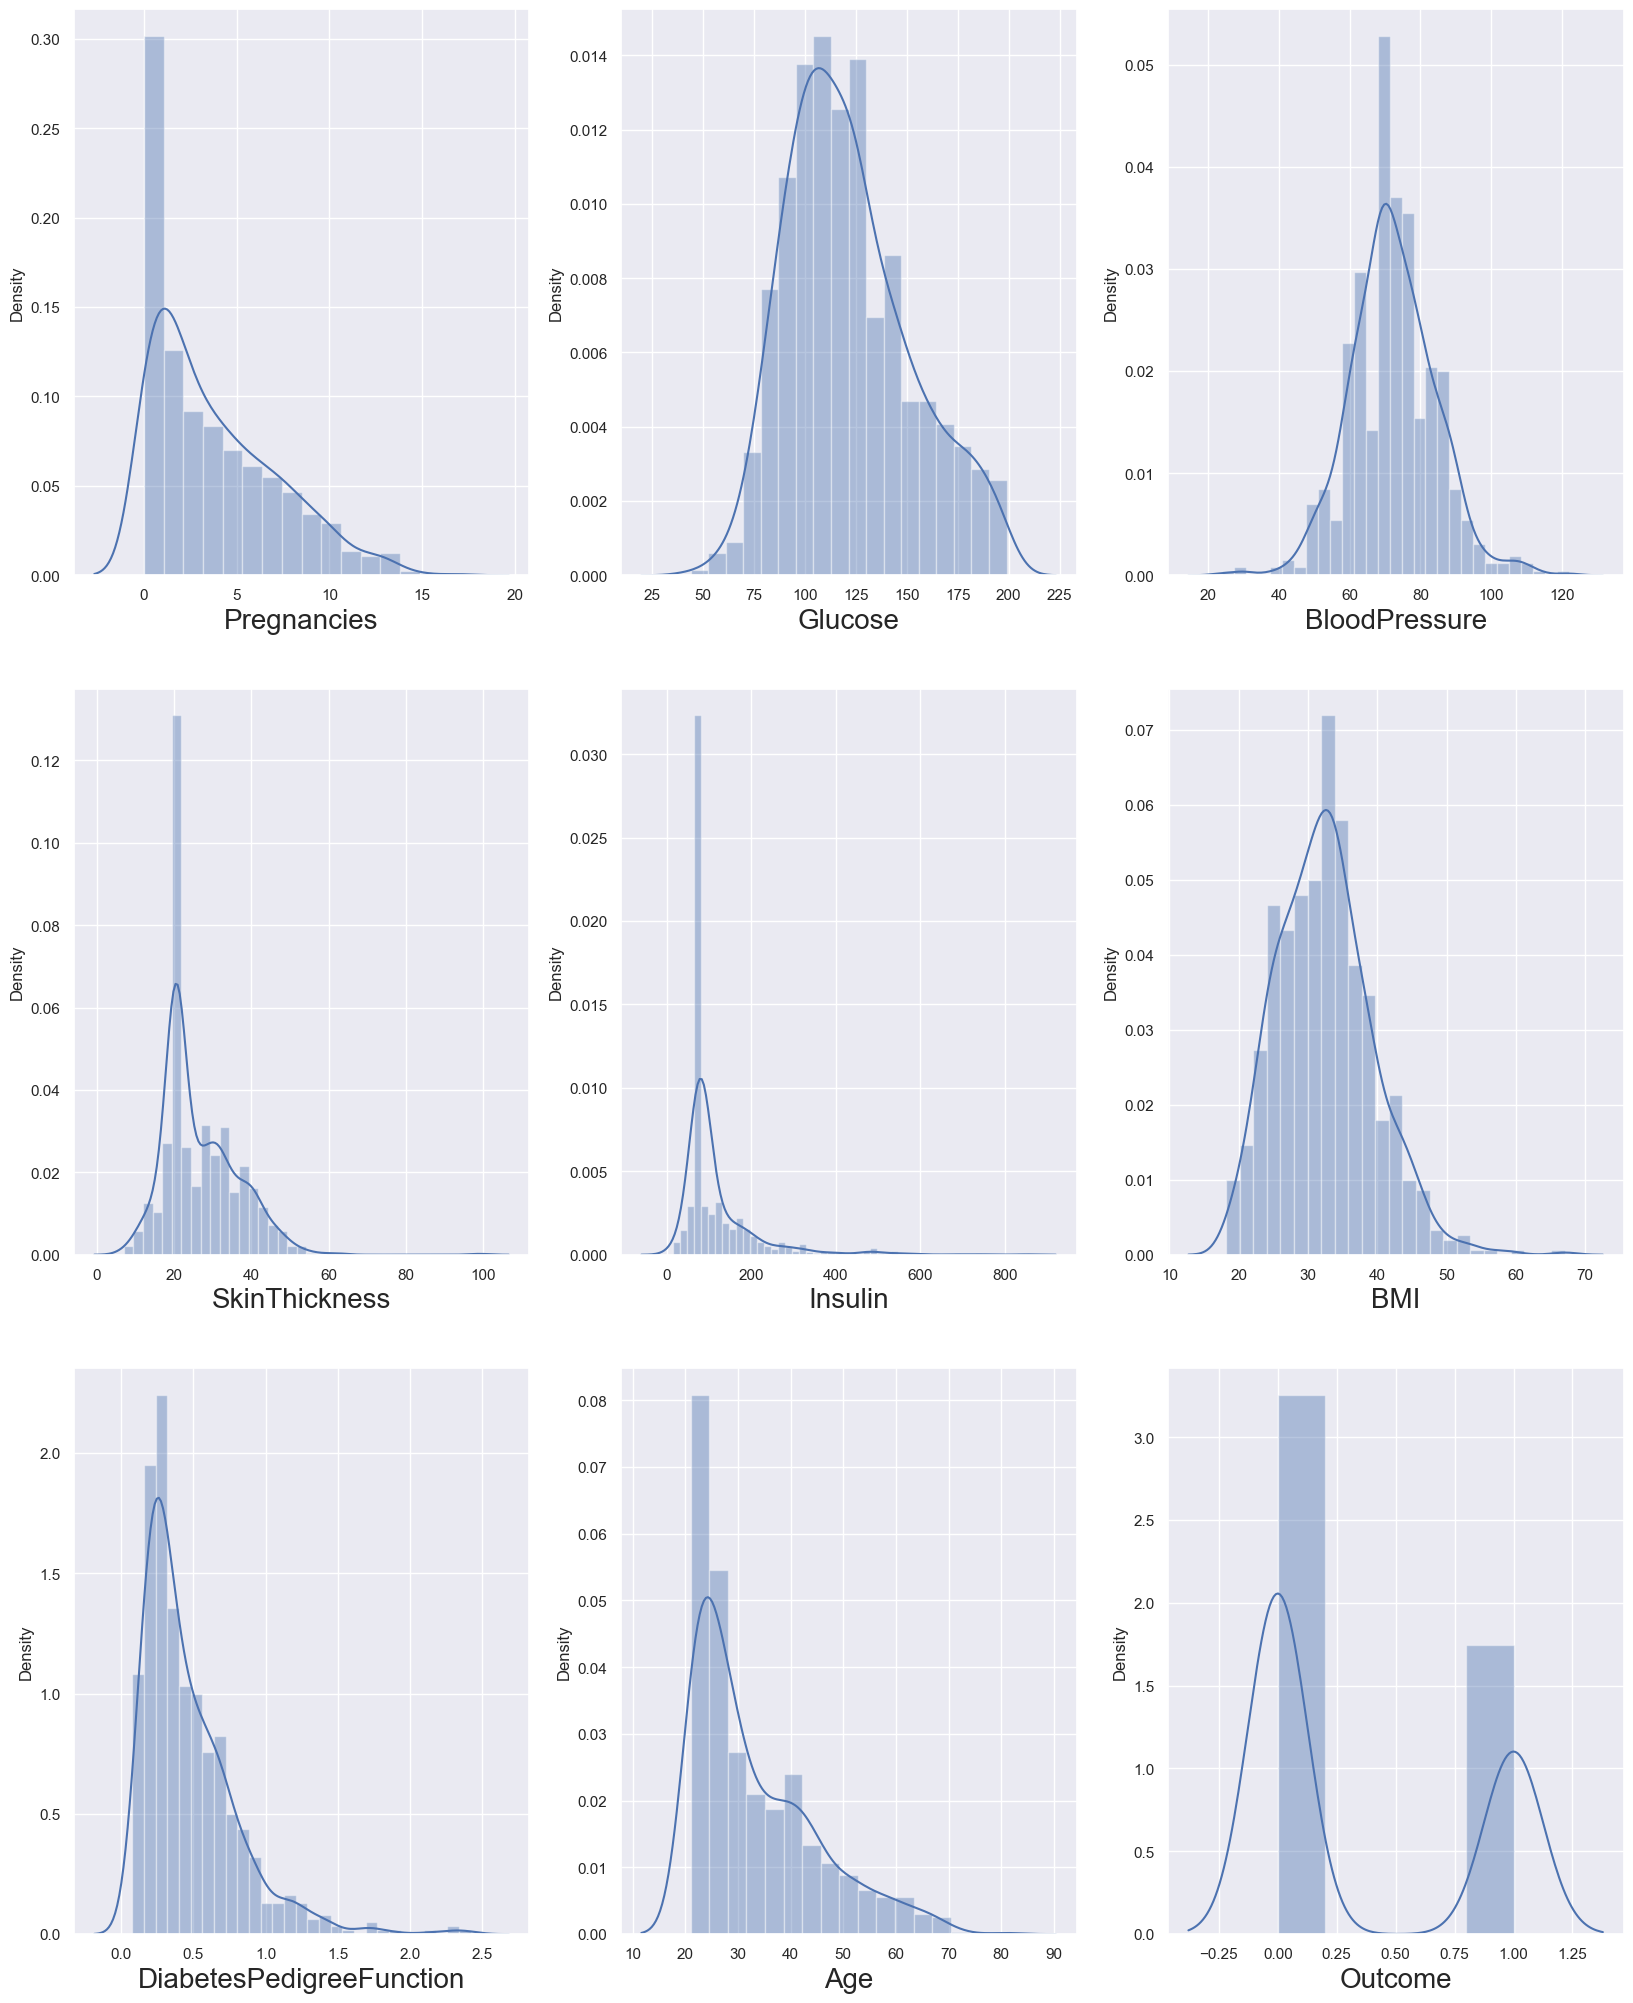

In [12]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data:
    if plotnumber<=9 :
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(data[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.show()

Now we have dealt with the 0 values and data looks better. But, there still are outliers present in some columns. Let's deal with them.

<Axes: >

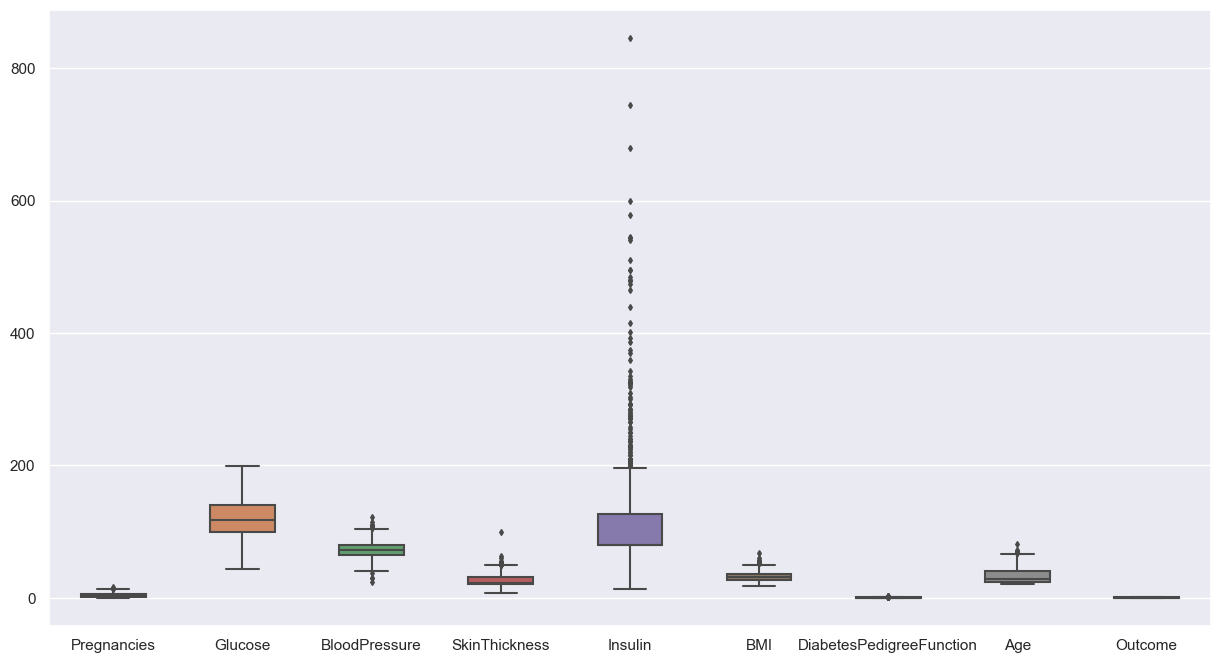

In [13]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=data, width= 0.5,ax=ax,  fliersize=3)

In [14]:
q = data['Pregnancies'].quantile(0.98)
# we are removing the top 2% data from the Pregnancies column
data_cleaned = data[data['Pregnancies']<q]
q = data_cleaned['BMI'].quantile(0.99)
# we are removing the top 1% data from the BMI column
data_cleaned  = data_cleaned[data_cleaned['BMI']<q]
q = data_cleaned['SkinThickness'].quantile(0.99)
# we are removing the top 1% data from the SkinThickness column
data_cleaned  = data_cleaned[data_cleaned['SkinThickness']<q]
q = data_cleaned['Insulin'].quantile(0.95)
# we are removing the top 5% data from the Insulin column
data_cleaned  = data_cleaned[data_cleaned['Insulin']<q]
q = data_cleaned['DiabetesPedigreeFunction'].quantile(0.99)
# we are removing the top 1% data from the DiabetesPedigreeFunction column
data_cleaned  = data_cleaned[data_cleaned['DiabetesPedigreeFunction']<q]
q = data_cleaned['Age'].quantile(0.99)
# we are removing the top 1% data from the Age column
data_cleaned  = data_cleaned[data_cleaned['Age']<q]

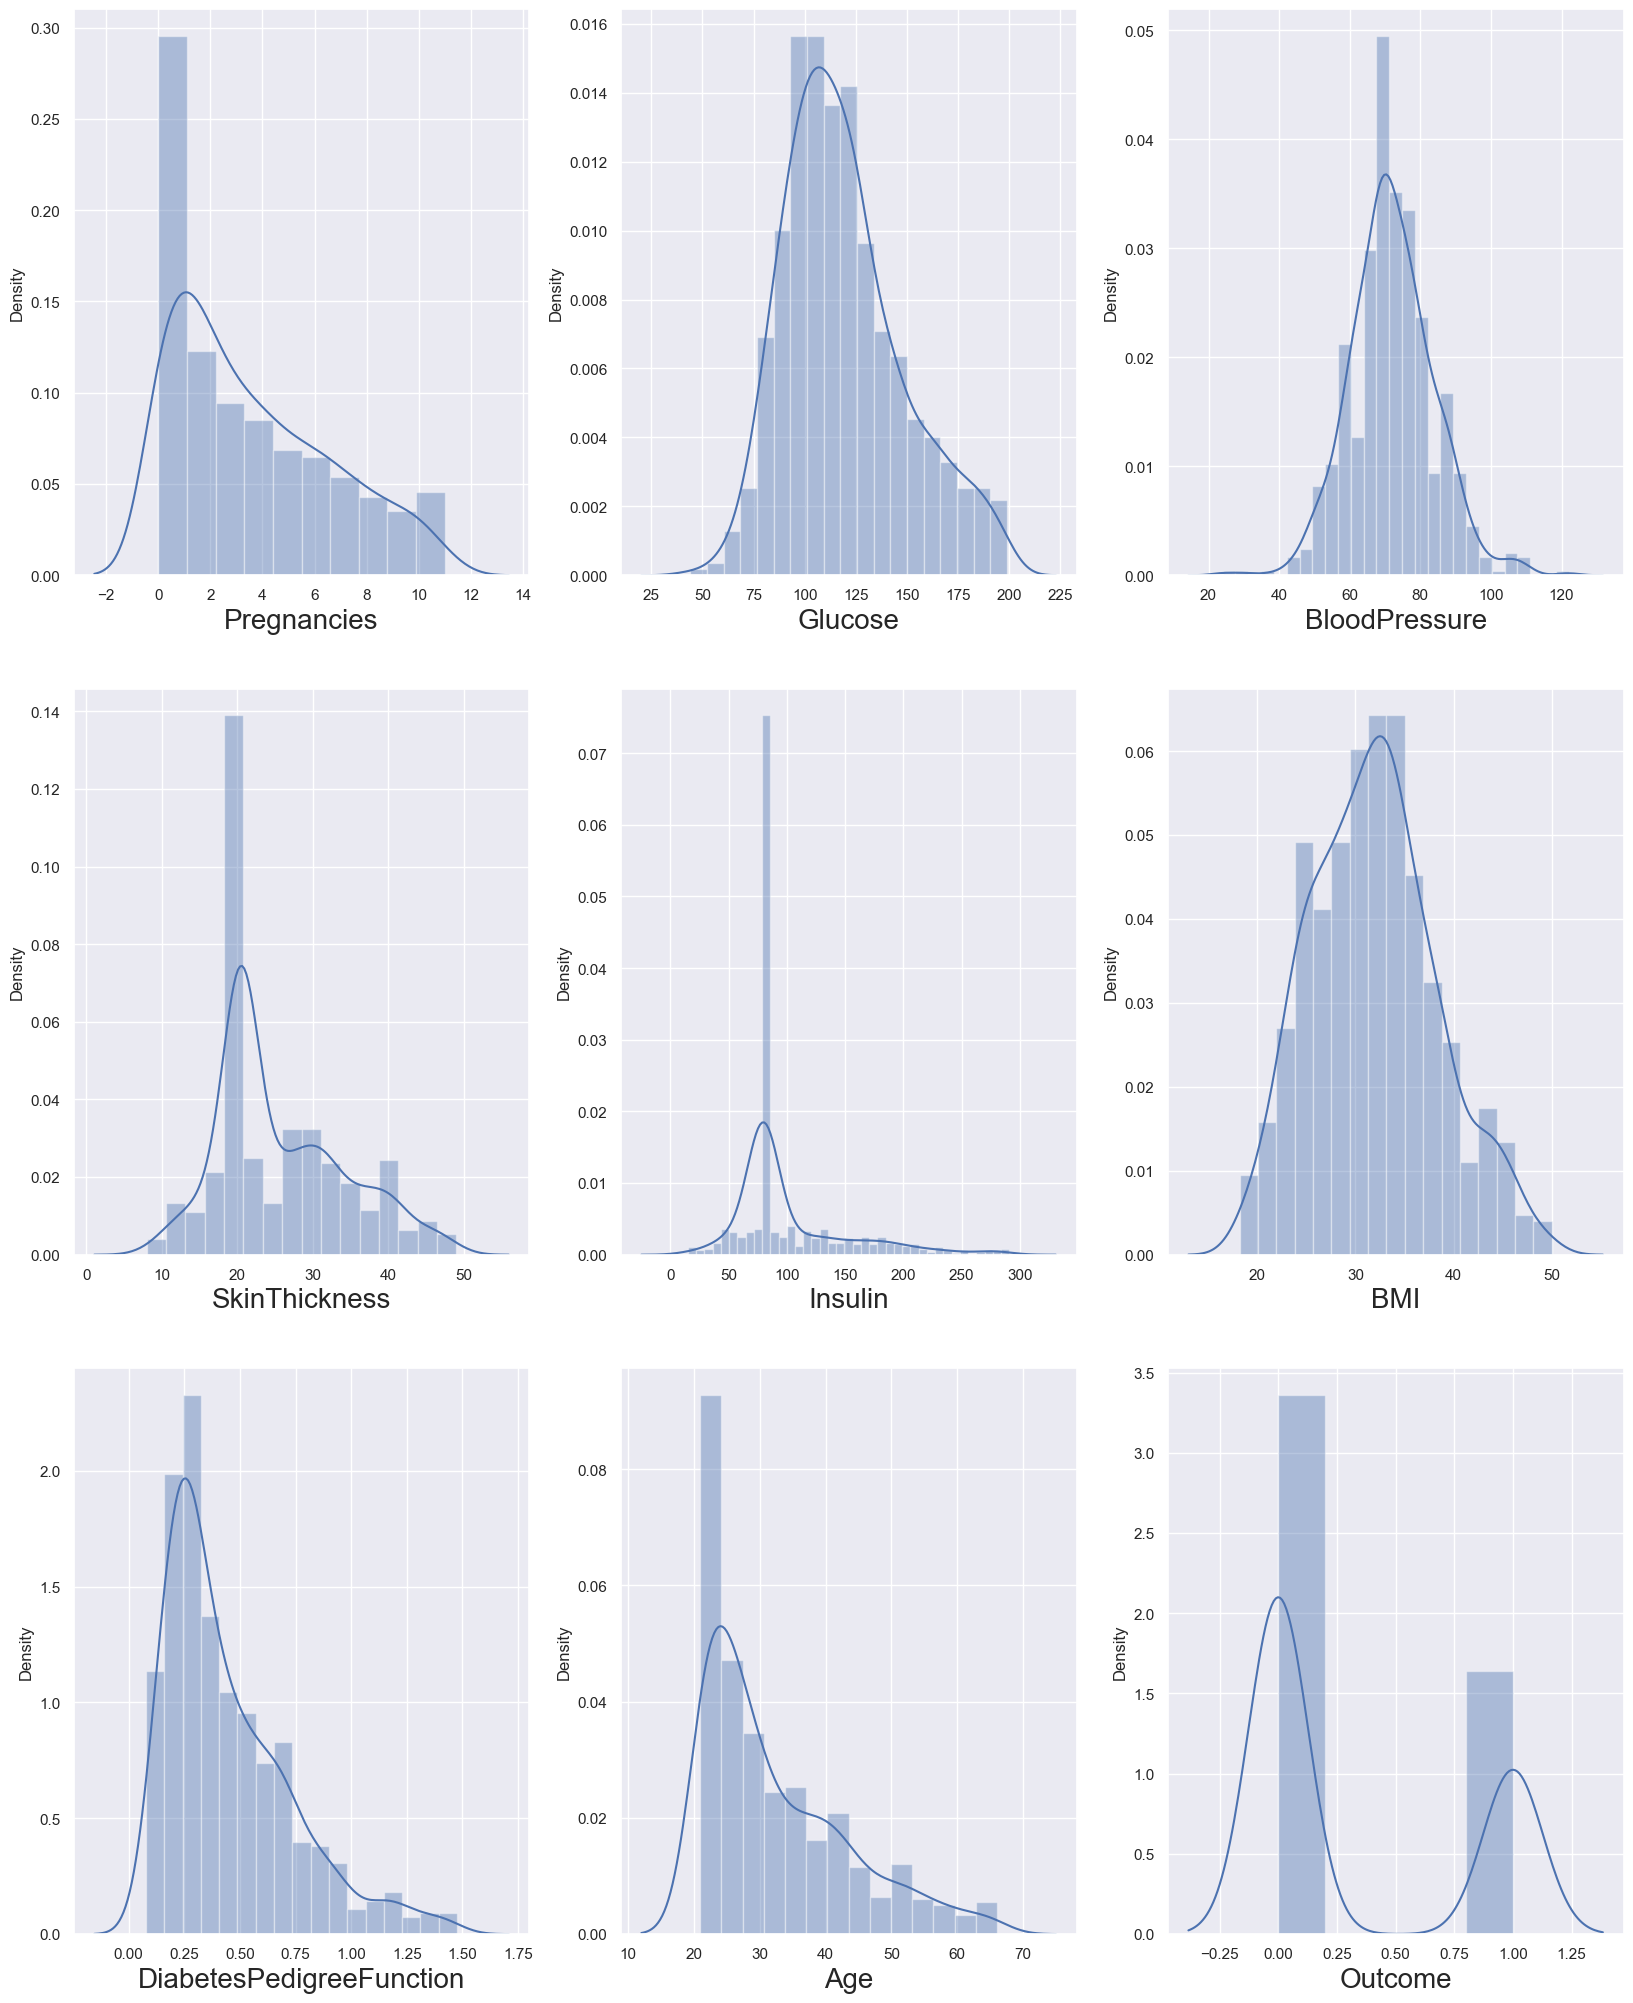

In [15]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in data_cleaned:
    if plotnumber<=9 :
        ax = plt.subplot(3,3,plotnumber)
        sns.distplot(data_cleaned[column])
        plt.xlabel(column,fontsize=20)
        #plt.ylabel('Salary',fontsize=20)
    plotnumber+=1
plt.show()

The data looks much better now than before. We will start our analysis with this data now as we don't want to lose important information. If our model doesn't work with accuracy, we will come back for more preprocessing.

In [16]:
X = data.drop(columns = ['Outcome'])
y = data['Outcome']

Let's proceed by checking multicollinearity in the dependent variables. Before that, we should scale our data. Let's use the standard scaler for that.

In [18]:
scalar = StandardScaler()
X_scaled = scalar.fit_transform(X)

This is how our data looks now after scaling. Great, now we will check for multicollinearity using VIF(Variance Inflation factor)

In [19]:
X_scaled

array([[ 0.63994726,  0.86527574, -0.0210444 , ...,  0.16725546,
         0.46849198,  1.4259954 ],
       [-0.84488505, -1.20598931, -0.51658286, ..., -0.85153454,
        -0.36506078, -0.19067191],
       [ 1.23388019,  2.01597855, -0.68176235, ..., -1.33182125,
         0.60439732, -0.10558415],
       ...,
       [ 0.3429808 , -0.02240928, -0.0210444 , ..., -0.90975111,
        -0.68519336, -0.27575966],
       [-0.84488505,  0.14197684, -1.01212132, ..., -0.34213954,
        -0.37110101,  1.17073215],
       [-0.84488505, -0.94297153, -0.18622389, ..., -0.29847711,
        -0.47378505, -0.87137393]])

In [20]:
type(X_scaled)

numpy.ndarray

In [21]:
pd.DataFrame(X_scaled)

,0,1,2,3,4,5,6,7
0,0.639947,0.865276,-0.021044,0.872057,-0.417768,0.167255,0.468492,1.425995
1,-0.844885,-1.205989,-0.516583,0.248678,-0.417768,-0.851535,-0.365061,-0.190672
2,1.233880,2.015979,-0.681762,-0.630654,-0.417768,-1.331821,0.604397,-0.105584
3,-0.844885,-1.074480,-0.516583,-0.374700,-0.265107,-0.633222,-0.920763,-1.041549
4,-1.141852,0.503626,-2.663916,0.872057,0.530423,1.549899,5.484909,-0.020496
...,...,...,...,...,...,...,...,...
763,1.827813,-0.679954,0.309315,2.222711,0.659428,0.065376,-0.908682,2.532136
764,-0.547919,0.010468,-0.186224,0.040885,-0.417768,0.632988,-0.398282,-0.531023
765,0.342981,-0.022409,-0.021044,-0.374700,-0.071599,-0.909751,-0.685193,-0.275760
766,-0.844885,0.141977,-1.012121,-0.630654,-0.417768,-0.342140,-0.371101,1.170732


<Axes: >

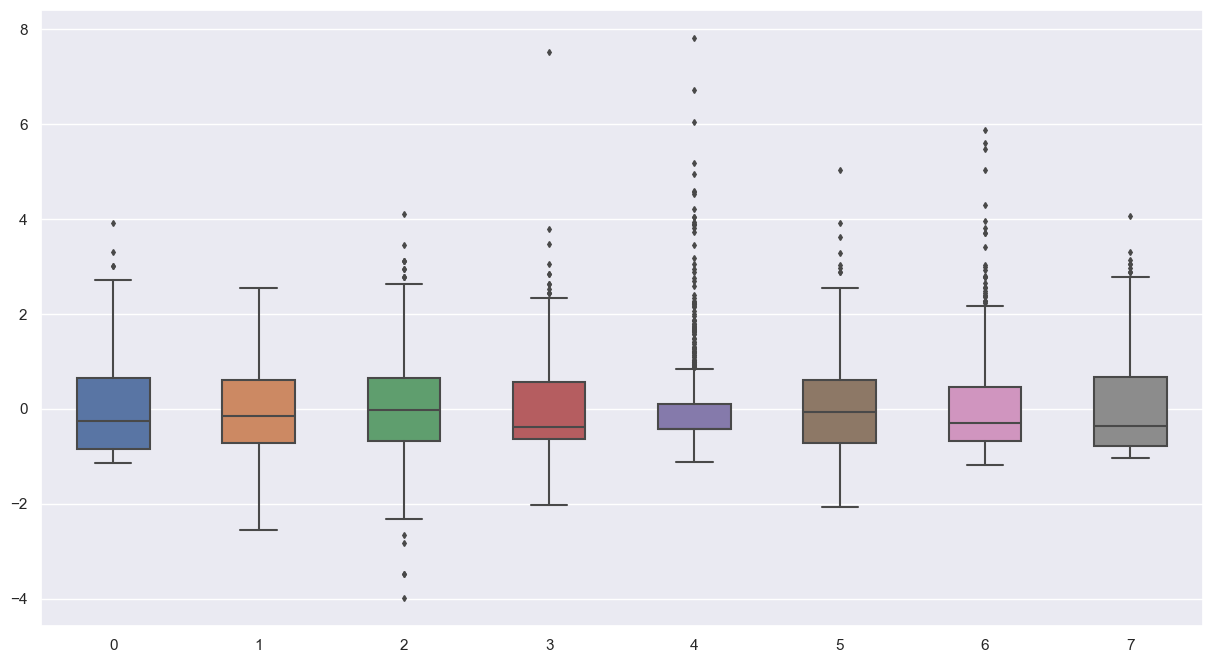

In [22]:
fig, ax = plt.subplots(figsize=(15,8))
sns.boxplot(data=X_scaled, width= 0.5,ax=ax,  fliersize=3)

In [23]:
vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])]
vif["Features"] = X.columns

#let's check the values
vif

,vif,Features
0,1.431075,Pregnancies
1,1.347308,Glucose
2,1.247914,BloodPressure
3,1.450510,SkinThickness
4,1.262111,Insulin
5,1.550227,BMI
6,1.058104,DiabetesPedigreeFunction
7,1.605441,Age


All the VIF values are less than 5 and are very low. That means no multicollinearity. Now, we can go ahead with fitting our data to the model. Before that, let's split our data in test and training set.

In [24]:
x_train,x_test,y_train,y_test = train_test_split(X_scaled,y, test_size= 0.25, random_state = 355)

In [25]:
log_reg = LogisticRegression()

log_reg.fit(x_train,y_train)

LogisticRegression()

In [26]:
import pickle
# Writing different model files to file
with open( 'modelForPrediction.sav', 'wb') as f:
    pickle.dump(log_reg,f)
    
with open('sandardScalar.sav', 'wb') as f:
    pickle.dump(scalar,f)

Let's see how well our model performs on the test data set.

In [27]:
y_pred = log_reg.predict(x_test)

In [28]:
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.7552083333333334

In [29]:
# Confusion Matrix
conf_mat = confusion_matrix(y_test,y_pred)
conf_mat

array([[110,  15],
       [ 32,  35]], dtype=int64)

In [30]:
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [31]:
# Breaking down the formula for Accuracy
Accuracy = (true_positive + true_negative) / (true_positive +false_positive + false_negative + true_negative)
Accuracy

0.7552083333333334

In [32]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.88

In [33]:
# Recall
Recall = true_positive/(true_positive+false_negative)
Recall

0.7746478873239436

In [34]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.8239700374531835

In [35]:
# Area Under Curve
auc = roc_auc_score(y_test, y_pred)
auc

0.7011940298507463

### ROC

In [36]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

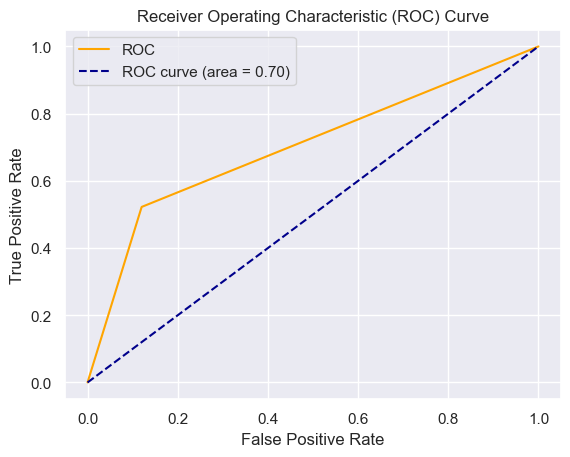

In [37]:
plt.plot(fpr, tpr, color='orange', label='ROC')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--',label='ROC curve (area = %0.2f)' % auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

### What is the significance of Roc curve and AUC?

In real life, we create various models using different algorithms that we can use for classification purpose. We use AUC to determine which model is the best one to use for a given dataset. Suppose we have created Logistic regression, SVM as well as a clustering model for classification purpose. We will calculate AUC for all the models seperately. The model with highest AUC value will be the best model to use.